In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('selected df.csv')
df.head()

,SAL_FLAG,CHANNEL_CODE_GROUPED,has_delinquency,HAS_INSURANCE,emi_stress_flag,active_loans,Bureau_prd_grouped,enquiry_risk,open_TL_ratio,LOG_income_sum,REQUESTED_TENURE,Doc_form_16,LTV_sq,ever60_24m_StrictFlag
0,1,2,0,1,0,1,2,2,-0.184962,-2.193629,0.109001,0,0.515865,0
1,0,2,1,1,0,1,1,1,-0.624892,-0.121980,-0.854460,0,-0.509784,0
2,0,1,0,1,0,1,0,1,1.134819,-0.416014,0.109001,0,-0.395944,0
3,1,2,0,1,0,1,1,1,-0.184965,1.028352,0.109001,0,-0.550967,0
4,1,2,0,0,1,0,2,1,-1.504750,-1.138480,1.457847,0,-0.673194,0


In [3]:
df.shape

(12143, 14)

In [4]:
#Splitting data into input features X and target y

X = df.drop(['ever60_24m_StrictFlag'], axis = 1, )
y = df['ever60_24m_StrictFlag']

In [5]:
X.shape

(12143, 13)

In [6]:
y.shape

(12143,)

In [7]:
y.value_counts()

ever60_24m_StrictFlag
0    11288
1      855
Name: count, dtype: int64

Target class is heavily imbalanced

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

Test - Train Split

In [19]:
#Split the data before resampling inorder to prevent data leak into test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.2, random_state=42) 
#Stratified to ensure class distribution of your target variable is preserved in both the training and test sets.

In [21]:
y_train.value_counts()

ever60_24m_StrictFlag
0    9030
1     684
Name: count, dtype: int64

1. Over Sampling - SMOTE

In [24]:
#Apply SMOTE only to the training data

from imblearn.over_sampling import SMOTE
# Resampling the minority class.
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [26]:
y_sm.value_counts()

ever60_24m_StrictFlag
0    9030
1    9030
Name: count, dtype: int64

1. Logistic Regression

In [71]:
logreg_sm = LogisticRegression()
logreg_sm.fit(X_sm,y_sm)

logreg_pred = logreg_sm.predict(X_test)  #prediction of classes
logreg_proba = logreg_sm.predict_proba(X_test)[:, 1]  #prediction of probability of 1 class

print("Classification report\n",classification_report(y_test, logreg_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, logreg_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, logreg_proba))

Classification report
               precision    recall  f1-score   support

           0       0.96      0.68      0.80      2258
           1       0.12      0.58      0.20       171

    accuracy                           0.67      2429
   macro avg       0.54      0.63      0.50      2429
weighted avg       0.90      0.67      0.75      2429


 Confusion matrix :
 [[1539  719]
 [  71  100]]

Test ROC-AUC: 0.6554965062493849


In [31]:
#Applying hyperparameters and threshold tuning
#Lowering the Threshold when missing a positive case is costly e.g., letting a defaulter get a loan → financial loss

log_parameters ={'C':[0.01,0.1,1],
             'penalty':['l1','l2'],
             'solver':['liblinear'],
              'class_weight': [None,'balanced']}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_grid = GridSearchCV(estimator = logreg_sm,
                           param_grid = log_parameters,
                           cv = skf,
                           scoring = 'roc_auc',
                           verbose=1,
                           n_jobs=-1
                          )
logreg_grid.fit(X_sm, y_sm)

logreg_grid_pred = logreg_grid.best_estimator_.predict(X_test)
logreg_grid_proba = logreg_grid.best_estimator_.predict_proba(X_test)[:, 1]
logreg_grid_pred_custom = (logreg_grid_proba >= 0.3).astype(int) 

print("\n Classification Report (custom threshold):\n", classification_report(y_test, logreg_grid_pred_custom))
print("\n Confusion Matrix (custom threshold):\n", confusion_matrix(y_test, logreg_grid_pred_custom))
print("\nTest ROC-AUC:", roc_auc_score(y_test, logreg_grid_proba))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Classification Report (custom threshold):
               precision    recall  f1-score   support

           0       0.96      0.33      0.49      2258
           1       0.09      0.84      0.16       171

    accuracy                           0.36      2429
   macro avg       0.53      0.58      0.32      2429
weighted avg       0.90      0.36      0.46      2429


 Confusion Matrix (custom threshold):
 [[ 737 1521]
 [  27  144]]

Test ROC-AUC: 0.6556544890422099


Very high recall (0.84) for class 1 → better positive case identification.  Massive drop in accuracy (0.36) due to many false positives

2. Tuned Logistic Regression with Manual Class Weights

In [34]:
logreg_manual = LogisticRegression(solver='newton-cg', max_iter=1000)


weights = np.linspace(0.0, 0.99, 200)  
parameters = {'class_weight': [{0: w, 1: 1.0 - w} for w in weights]}


logreg_manual_grid = GridSearchCV(
    estimator = logreg_manual,
    param_grid=parameters,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',         
    n_jobs=-1,
    verbose=2
)

logreg_manual_grid.fit(X_sm, y_sm)

logreg_manual_grid_pred = logreg_manual_grid.best_estimator_.predict(X_test)
logreg_manual_grid_proba = logreg_manual_grid.best_estimator_.predict_proba(X_test)[:, 1]
logreg_manual_grid_pred_custom = (logreg_manual_grid_proba >= 0.3).astype(int) 

print("Classification Report:\n", classification_report(y_test, logreg_manual_grid_pred_custom))
print("\n Confusion Matrix (custom threshold):\n", confusion_matrix(y_test, logreg_manual_grid_pred_custom))
print("\nROC-AUC Score:", roc_auc_score(y_test, logreg_manual_grid_proba))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.29      0.45      2258
           1       0.08      0.87      0.15       171

    accuracy                           0.33      2429
   macro avg       0.53      0.58      0.30      2429
weighted avg       0.90      0.33      0.43      2429


 Confusion Matrix (custom threshold):
 [[ 657 1601]
 [  23  148]]

ROC-AUC Score: 0.6555483038863767


3. RandomForestClassifier

In [36]:
rf_sm = RandomForestClassifier(random_state=42, n_jobs = -1)
rf_sm.fit(X_sm, y_sm)

rf_pred = rf_sm.predict(X_test)
rf_proba = rf_sm.predict_proba(X_test)[:, 1]

print("Classification report\n",classification_report(y_test, rf_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, rf_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, rf_proba))

Classification report
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      2258
           1       0.19      0.18      0.18       171

    accuracy                           0.89      2429
   macro avg       0.56      0.56      0.56      2429
weighted avg       0.89      0.89      0.89      2429


 Confusion matrix :
 [[2129  129]
 [ 141   30]]

Test ROC-AUC: 0.6759436234518982


In [37]:
#Applying hyperparameters and threshold tuning

rf_parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': [None] 
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_grid = GridSearchCV(estimator=rf_sm, param_grid=rf_parameters, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
rf_grid.fit(X_sm, y_sm)

rf_grid_pred = rf_grid.best_estimator_.predict(X_test)
rf_grid_proba = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]
rf_grid_pred_custom = (rf_grid_proba >= 0.3).astype(int)
print("Classification report\n",classification_report(y_test, rf_grid_pred_custom))
print("\n Confusion matrix :\n", confusion_matrix(y_test, rf_grid_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, rf_grid_proba))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification report
               precision    recall  f1-score   support

           0       0.95      0.79      0.86      2258
           1       0.13      0.42      0.20       171

    accuracy                           0.76      2429
   macro avg       0.54      0.60      0.53      2429
weighted avg       0.89      0.76      0.81      2429


 Confusion matrix :
 [[2128  130]
 [ 143   28]]

Test ROC-AUC: 0.6798672944540269


4. XGBoost Classifier

In [39]:
xgb_sm = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='aucpr')
xgb_sm.fit(X_sm, y_sm)

xgb_pred = xgb_sm.predict(X_test)
xgb_proba = xgb_sm.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, xgb_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, xgb_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2258
           1       0.12      0.12      0.12       171

    accuracy                           0.88      2429
   macro avg       0.53      0.53      0.53      2429
weighted avg       0.88      0.88      0.88      2429


 Confusion matrix :
 [[2108  150]
 [ 150   21]]

Test ROC-AUC: 0.600233607342833


In [40]:
#Applying hyperparameters and threshold tuning

parameters = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

xgb_grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='aucpr'),
    param_grid=parameters,
    scoring='average_precision',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
xgb_grid.fit(X_sm, y_sm)

xgb_grid_pred = xgb_grid.best_estimator_.predict(X_test)
xgb_grid_proba = xgb_grid.best_estimator_.predict_proba(X_test)[:, 1]
xgb_grid_pred_custom = (xgb_grid_proba >= 0.3).astype(int)
print("Classification Report:\n", classification_report(y_test, xgb_grid_pred_custom))
print("\n Confusion matrix :\n", confusion_matrix(y_test, xgb_grid_pred_custom))
print("\nTest ROC-AUC:", roc_auc_score(y_test, xgb_grid_proba))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      2258
           1       0.16      0.22      0.18       171

    accuracy                           0.87      2429
   macro avg       0.55      0.57      0.56      2429
weighted avg       0.88      0.87      0.87      2429


 Confusion matrix :
 [[2066  192]
 [ 134   37]]

Test ROC-AUC: 0.6335809260381541


5. SVM

In [42]:
svm_sm = SVC(probability=True, random_state=42)
svm_sm.fit(X_sm, y_sm)

svm_pred = svm_sm.predict(X_test)
svm_proba = svm_sm.predict_proba(X_test)[:, 1]


print("Classification Report:\n", classification_report(y_test, svm_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, svm_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      2258
           1       0.12      0.45      0.19       171

    accuracy                           0.73      2429
   macro avg       0.53      0.60      0.51      2429
weighted avg       0.89      0.73      0.79      2429


Confusion Matrix:
 [[1690  568]
 [  94   77]]

Test ROC-AUC: 0.6303306243169187


In [43]:
svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid={
        'C': [0.1, 1, 10],                  
        'kernel': ['rbf'],            
        'gamma': ['scale']            
    },
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_sm, y_sm)

svm_grid_pred = svm_grid.best_estimator_.predict(X_test)
svm_grid_proba = svm_grid.best_estimator_.predict_proba(X_test)[:, 1]
svm_grid_pred_custom = (svm_grid_proba >= 0.3).astype(int)

print("Classification Report:\n", classification_report(y_test, svm_grid_pred_custom))
print("\n Confusion matrix :\n", confusion_matrix(y_test, svm_grid_pred_custom))
print("\nTest ROC-AUC:", roc_auc_score(y_test, svm_grid_proba))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.70      0.80      2258
           1       0.11      0.47      0.17       171

    accuracy                           0.68      2429
   macro avg       0.53      0.59      0.49      2429
weighted avg       0.89      0.68      0.76      2429


 Confusion matrix :
 [[1578  680]
 [  90   81]]

Test ROC-AUC: 0.6135857432183944


6. Decision Tree Classifier

In [45]:
dt_sm = DecisionTreeClassifier(random_state=42)
dt_sm.fit(X_sm, y_sm)

dt_pred = dt_sm.predict(X_test)
dt_proba = dt_sm.predict_proba(X_test)[:, 1]


print("Classification Report:\n", classification_report(y_test, dt_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, dt_pred))
print("\nTest ROC-AUC:", roc_auc_score(y_test, dt_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      2258
           1       0.12      0.26      0.16       171

    accuracy                           0.81      2429
   macro avg       0.53      0.55      0.53      2429
weighted avg       0.88      0.81      0.84      2429


Confusion Matrix:
 [[1920  338]
 [ 127   44]]

Test ROC-AUC: 0.5538099751889319


In [46]:
dt_params = {
    'max_depth': [3, 5, 10],           # Limit tree depth
    'min_samples_split': [2, 5],       # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2],        # Minimum samples at a leaf node
    'criterion': ['gini', 'entropy']   # Impurity measure
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_sm, y_sm)

dt_grid_pred = dt_grid.best_estimator_.predict(X_test)
dt_grid_proba = dt_grid.best_estimator_.predict_proba(X_test)[:, 1]
dt_grid_pred_custom = (dt_grid_proba >= 0.3).astype(int)

print("Classification Report:\n", classification_report(y_test, dt_grid_pred_custom))
print("\n Confusion matrix :\n", confusion_matrix(y_test, dt_grid_pred_custom))
print("\nTest ROC-AUC:", roc_auc_score(y_test, dt_grid_proba))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.61      0.74      2258
           1       0.09      0.51      0.16       171

    accuracy                           0.61      2429
   macro avg       0.52      0.56      0.45      2429
weighted avg       0.88      0.61      0.70      2429


 Confusion matrix :
 [[1384  874]
 [  83   88]]

Test ROC-AUC: 0.5590894493393211


7. Naive Bayes - GaussianNB variant

In [49]:
nb_sm = GaussianNB()
nb_sm.fit(X_sm, y_sm)


nb_pred = nb_sm.predict(X_test)
nb_proba = nb_sm.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, nb_pred))
print("\n Confusion matrix :\n", confusion_matrix(y_test, nb_pred))
print("\nTest ROC-AUC Score:", roc_auc_score(y_test, nb_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.60      0.73      2258
           1       0.11      0.63      0.18       171

    accuracy                           0.60      2429
   macro avg       0.53      0.61      0.46      2429
weighted avg       0.90      0.60      0.70      2429


 Confusion matrix :
 [[1346  912]
 [  63  108]]

Test ROC-AUC Score: 0.6526631755059334


2. Under Sampling - Random Undersampling

In [73]:
y.value_counts()

ever60_24m_StrictFlag
0    11288
1      855
Name: count, dtype: int64

In [75]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

y_rus.value_counts()

ever60_24m_StrictFlag
0    684
1    684
Name: count, dtype: int64

In [77]:
logreg_rus = LogisticRegression(class_weight='balanced')
logreg_rus.fit(X_rus, y_rus)
logreg_rus_pred = logreg_rus.predict(X_test)
logreg_rus_proba = logreg_rus.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, logreg_rus_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, logreg_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, logreg_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.63      0.76      2258
           1       0.13      0.74      0.22       171

    accuracy                           0.64      2429
   macro avg       0.55      0.69      0.49      2429
weighted avg       0.91      0.64      0.72      2429

Confusion Matrix:
 [[1418  840]
 [  44  127]]

Test ROC AUC: 0.7257263323647176


2. Random Forest

In [80]:
rf_rus = RandomForestClassifier(random_state=42)
rf_rus.fit(X_rus, y_rus)

rf_rus_pred = rf_rus.predict(X_test)
rf_rus_proba = rf_rus.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, rf_rus_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, rf_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76      2258
           1       0.12      0.65      0.20       171

    accuracy                           0.63      2429
   macro avg       0.54      0.64      0.48      2429
weighted avg       0.90      0.63      0.72      2429


Confusion Matrix:
 [[1417  841]
 [  60  111]]

Test ROC AUC: 0.7010965559751163


3. XGBoost

In [83]:
xgb_rus = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_rus.fit(X_rus, y_rus)

xgb_rus_pred = xgb_rus.predict(X_test)
xgb_rus_proba = xgb_rus.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, xgb_rus_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, xgb_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.60      0.74      2258
           1       0.11      0.64      0.18       171

    accuracy                           0.60      2429
   macro avg       0.53      0.62      0.46      2429
weighted avg       0.90      0.60      0.70      2429


Confusion Matrix:
 [[1349  909]
 [  61  110]]

Test ROC AUC: 0.6551106138537959


4. SVM

In [86]:
svm_rus = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_rus.fit(X_rus, y_rus)

svm_rus_pred = svm_rus.predict(X_test)
svm_rus_proba = svm_rus.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, svm_rus_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, svm_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.64      0.77      2258
           1       0.13      0.69      0.22       171

    accuracy                           0.65      2429
   macro avg       0.55      0.67      0.49      2429
weighted avg       0.91      0.65      0.73      2429


Confusion Matrix:
 [[1451  807]
 [  53  118]]

Test ROC AUC: 0.7165477910897704


5. Decision Tree

In [89]:
dt_rus = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_rus.fit(X_rus, y_rus)

dt_rus_pred = dt_rus.predict(X_test)
dt_rus_proba = dt_rus.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, dt_rus_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, dt_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, dt_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.56      0.70      2258
           1       0.10      0.61      0.17       171

    accuracy                           0.56      2429
   macro avg       0.52      0.59      0.43      2429
weighted avg       0.89      0.56      0.67      2429


Confusion Matrix:
 [[1264  994]
 [  66  105]]

Test ROC AUC: 0.586911255108542


6. Naive Bayes - Guassian

In [91]:
nb_rus = GaussianNB()
nb_rus.fit(X_rus, y_rus)


nb_rus_pred = nb_rus.predict(X_test)
nb_rus_proba = nb_rus.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, nb_rus_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, nb_rus_pred))
print("\nTest ROC AUC:", roc_auc_score(y_test, nb_rus_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.66      0.78      2258
           1       0.12      0.63      0.21       171

    accuracy                           0.66      2429
   macro avg       0.54      0.64      0.49      2429
weighted avg       0.90      0.66      0.74      2429


Confusion Matrix:
 [[1486  772]
 [  63  108]]

Test ROC AUC: 0.710922567712461


Model Comparison

Precision-Recall (PR) Curve Comparison:

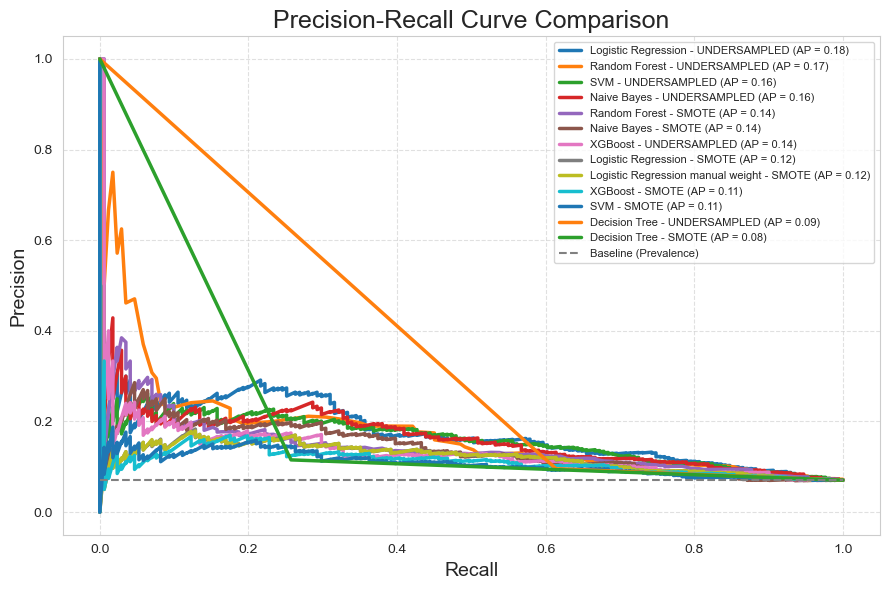

In [117]:
sns.set_style("whitegrid")

models_proba = {
    'Logistic Regression - SMOTE': logreg_grid_proba,
    'Logistic Regression manual weight - SMOTE': logreg_manual_grid_proba,
    'Random Forest - SMOTE': rf_grid_proba,
    'XGBoost - SMOTE': xgb_grid_proba,
    'SVM - SMOTE': svm_grid_proba,
    'Decision Tree - SMOTE': dt_proba,
    'Naive Bayes - SMOTE': nb_proba,
    'Logistic Regression - UNDERSAMPLED': logreg_rus_proba,
    'Random Forest - UNDERSAMPLED': rf_rus_proba,
    'XGBoost - UNDERSAMPLED': xgb_rus_proba,
    'SVM - UNDERSAMPLED': svm_rus_proba,
    'Decision Tree - UNDERSAMPLED': dt_rus_proba,
    'Naive Bayes - UNDERSAMPLED': nb_rus_proba
}

ap_scores = {
    name: average_precision_score(y_test, proba)
    for name, proba in models_proba.items()
}

sorted_models = sorted(ap_scores.items(), key=lambda x: x[1], reverse=True)


plt.figure(figsize=(9, 6))
colors = sns.color_palette('tab10', n_colors=len(models_proba))

for (name, ap), color in zip(sorted_models, colors):
    precision, recall, _ = precision_recall_curve(y_test, models_proba[name])
    plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})", lw=2.5, color=color)
    
baseline = y_test.sum() / len(y_test)
plt.hlines(y=baseline, xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (Prevalence)')

plt.title("Precision-Recall Curve Comparison", fontsize=18)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Insights:

1. Best Performing Models (based on AP):

Logistic Regression - Undersampled (AP = 0.18)

Random Forest - Undersampled (AP = 0.17)

SVM - Undersampled (AP = 0.16)

These outperform SMOTE-based variants, showing undersampling is more effective on your imbalanced dataset.

2. Sharp Declines & Flat Curves:

Models like Naive Bayes - Undersampled and Decision Tree - SMOTE show near-linear drops or flat behavior — a sign that they struggle with precision across recall values.

Flat curves usually indicate poor discrimination, i.e., the model fails to correctly rank positive samples.

3. SMOTE Models Generally Underperform:

Most SMOTE-based models (bottom of the legend) have lower AP, suggesting oversampling may be causing overfitting or noise injection.

4. PR Curve Behavior:

High precision at very low recall is common in imbalanced datasets.

The best models hold a higher precision across more recall range, e.g., LogReg & RF undersampled.

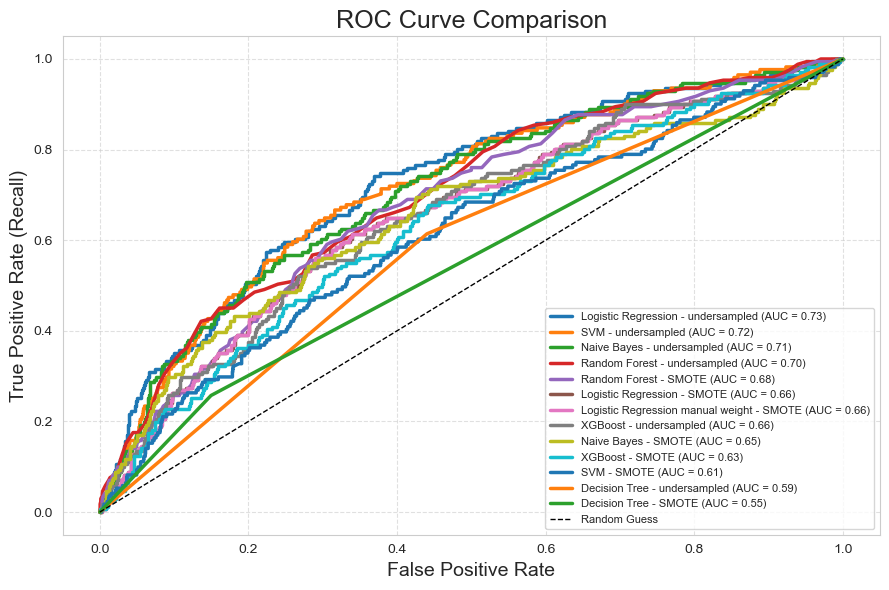

In [123]:
models_proba = {
    'Logistic Regression - SMOTE': logreg_grid_proba,
    'Logistic Regression manual weight - SMOTE': logreg_manual_grid_proba,
    'Random Forest - SMOTE': rf_grid_proba,
    'XGBoost - SMOTE': xgb_grid_proba,
    'SVM - SMOTE': svm_grid_proba,
    'Decision Tree - SMOTE': dt_proba,
    'Naive Bayes - SMOTE': nb_proba,
    'Logistic Regression - undersampled': logreg_rus_proba,
    'Random Forest - undersampled': rf_rus_proba,
    'XGBoost - undersampled': xgb_rus_proba,
    'SVM - undersampled': svm_rus_proba,
    'Decision Tree - undersampled': dt_rus_proba,
    'Naive Bayes - undersampled': nb_rus_proba
}

roc_scores = {
    name: roc_auc_score(y_test, proba)
    for name, proba in models_proba.items()
}

sorted_models = sorted(roc_scores.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(9, 6))
colors = sns.color_palette("tab10", n_colors=len(models_proba))

for (name, auc_score), color in zip(sorted_models, colors):
    fpr, tpr, _ = roc_curve(y_test, models_proba[name])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})", lw=2.5, color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Random Guess")

plt.title("ROC Curve Comparison", fontsize=18)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate (Recall)", fontsize=14)
plt.legend(loc='lower right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

1. Top Performers (by AUC):

Logistic Regression - undersampled (AUC = 0.73)

SVM - undersampled (AUC = 0.72)

Naive Bayes - undersampled (AUC = 0.71)

These models outperform others in distinguishing between classes.

2. Undersampling beats SMOTE:

Every undersampled model is above or comparable to its SMOTE counterpart, which matches your PR curve results too.

This suggests your dataset might be more compatible with undersampling (perhaps due to significant noise or overlap in the minority class that SMOTE exaggerates).

3. Decision Trees perform worst:

Both SMOTE and undersampled variants of Decision Tree perform poorly (AUCs of 0.55 and 0.59 respectively), barely above random guess.



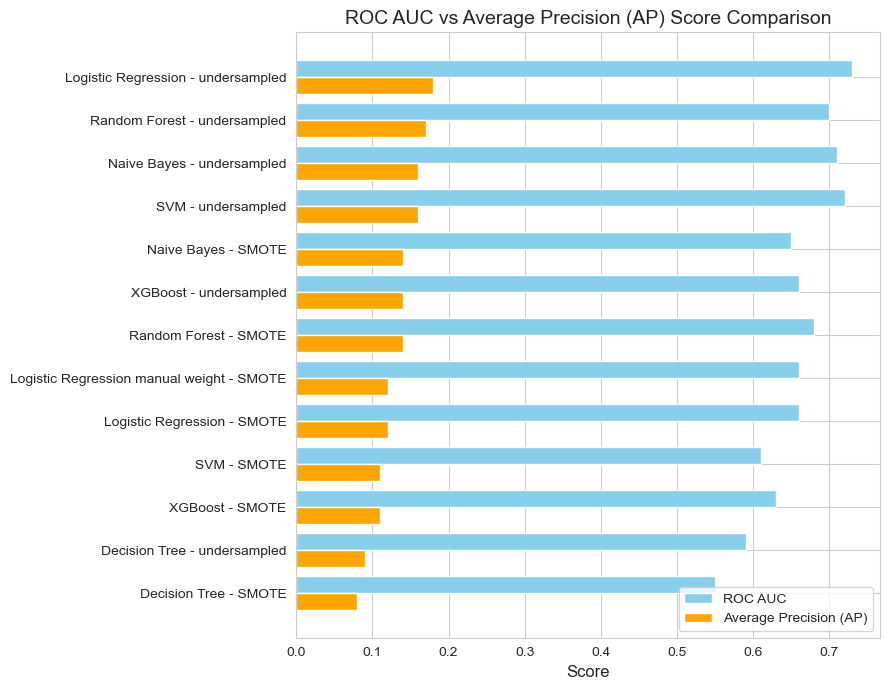

In [128]:
roc_scores = {
    'Logistic Regression - undersampled': 0.73,
    'SVM - undersampled': 0.72,
    'Naive Bayes - undersampled': 0.71,
    'Random Forest - undersampled': 0.70,
    'Random Forest - SMOTE': 0.68,
    'Logistic Regression - SMOTE': 0.66,
    'Logistic Regression manual weight - SMOTE': 0.66,
    'XGBoost - undersampled': 0.66,
    'Naive Bayes - SMOTE': 0.65,
    'XGBoost - SMOTE': 0.63,
    'SVM - SMOTE': 0.61,
    'Decision Tree - undersampled': 0.59,
    'Decision Tree - SMOTE': 0.55
}

ap_scores = {
    'Logistic Regression - undersampled': 0.18,
    'Random Forest - undersampled': 0.17,
    'SVM - undersampled': 0.16,
    'Naive Bayes - undersampled': 0.16,
    'Random Forest - SMOTE': 0.14,
    'Naive Bayes - SMOTE': 0.14,
    'XGBoost - undersampled': 0.14,
    'Logistic Regression - SMOTE': 0.12,
    'Logistic Regression manual weight - SMOTE': 0.12,
    'XGBoost - SMOTE': 0.11,
    'SVM - SMOTE': 0.11,
    'Decision Tree - undersampled': 0.09,
    'Decision Tree - SMOTE': 0.08
}

# Merge into a DataFrame
df_scores = pd.DataFrame({
    'Model': list(roc_scores.keys()),
    'ROC AUC': list(roc_scores.values()),
    'Average Precision': [ap_scores[m] for m in roc_scores.keys()]
})

# Sort by ROC AUC or AP
df_scores.sort_values(by='Average Precision', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(9, 7))
sns.set_style("whitegrid")

bar_width = 0.4
positions = range(len(df_scores))

# ROC AUC bars
plt.barh([p + bar_width for p in positions], df_scores['ROC AUC'], bar_width, label='ROC AUC', color='skyblue')

# AP bars
plt.barh(positions, df_scores['Average Precision'], bar_width, label='Average Precision (AP)', color='orange')

# Y-ticks and labels
plt.yticks([p + bar_width / 2 for p in positions], df_scores['Model'], fontsize=10)
plt.xlabel("Score", fontsize=12)
plt.title("ROC AUC vs Average Precision (AP) Score Comparison", fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


1. Top 4 by AP (Precision-Recall focused):

Logistic Regression - undersampled (AP = 0.18) – also has highest ROC AUC (0.73): best overall

Random Forest - undersampled (AP = 0.17) – balanced and strong

SVM & Naive Bayes - undersampled (AP = 0.16) – decent ROC AUC and AP

All these models use undersampling, confirming it works better for your data than SMOTE.

2. Worst Performers:

Decision Tree - SMOTE (AP = 0.08) and undersampled (0.09) – both score lowest in AP and ROC AUC (not suitable)

3. SMOTE-based models consistently underperform in AP compared to undersampling, even when ROC AUC is moderate (e.g., Random Forest - SMOTE AUC = 0.68, but AP only 0.14).

Conclusion:

Undersampling worked better than SMOTE, likely due to model overfitting on synthetic data in SMOTE.

Average Precision (AP) is a better decision metric than ROC AUC for your case.

Logistic Regression - Undersampled is simple, interpretable, and performed the best overall. Use Logistic Regression (Undersampled) for default detection.

